# AI Tool for Actuaries

## Chapter 6: Regression Trees and Random Forests

### Authors: Michael Mayer and Mario Wuthrich
### Version May 2025

This Jupyter notebook calculates claim frequency models using decision trees and random forests. Furthermore, as an application of single decision trees, we use them to explain a random forest (black box).

In [1]:
# Load modules used throughout this chapter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_poisson_deviance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Load and inspect the data (this dataset contains counts and severities)
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


### Split into learn and test

In [3]:
# learning and test sample split (identical to Wuthrich-Merz, Springer 2023)
learn = df[df["LearnTest"] == "L"]
test = df[df["LearnTest"] == "T"]

### Turn categories into numbers

In [4]:
# Turn categories to numbers
x_num = ["DrivAge", "Density"]
x_cat = ["VehBrand", "VehGas", "Area"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", x_num),
        ("cat", OrdinalEncoder(), x_cat),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

### Define response and exposure

In [5]:
X_learn = preprocessor.fit_transform(learn)
X_test = preprocessor.transform(test)

y_learn = learn.ClaimNb / learn.Exposure
y_test = test.ClaimNb / test.Exposure

v_learn = learn.Exposure
v_test = test.Exposure

## Decision Tree

Let's fit a short decision tree minimizing Poisson deviance.

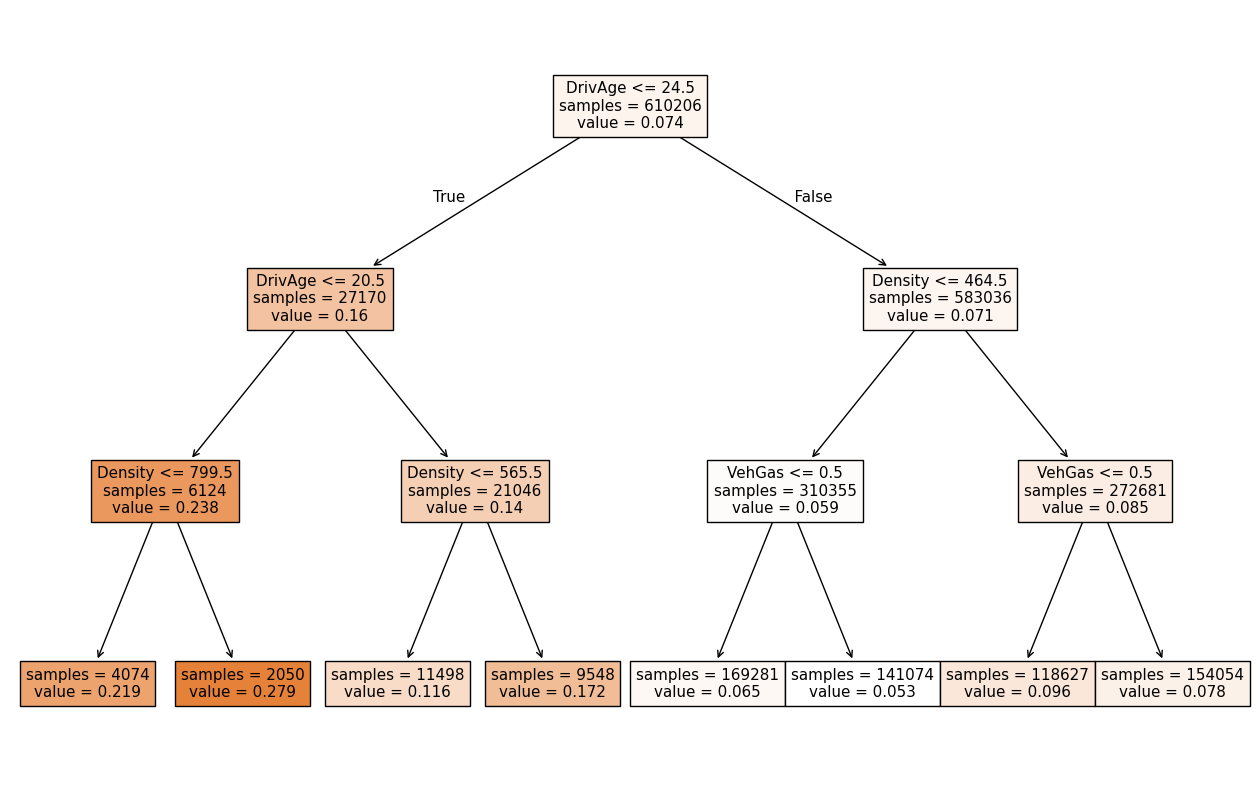

In [6]:
single_tree = DecisionTreeRegressor(criterion="poisson", max_depth=3)
single_tree.fit(X_learn, y=y_learn, sample_weight=v_learn)

plt.figure(figsize=(16, 10))
_ = tree.plot_tree(
    single_tree, feature_names=X_learn.columns, filled=True, impurity=False
)

### Performance

In [7]:
perf_learn = 100 * mean_poisson_deviance(
    y_learn, single_tree.predict(X_learn), sample_weight=v_learn
)

perf_test = 100 * mean_poisson_deviance(
    y_test, single_tree.predict(X_test), sample_weight=v_test
)

print(f"Poisson Deviance (Learn): {perf_learn:.3f}")
print(f"Poisson Deviance (Test): {perf_test:.3f}")

Poisson Deviance (Learn): 47.106
Poisson Deviance (Test): 47.331


## Random Forest

Let's use Scikit-Learn to fit a Poisson random forest.

The main tuning parameters

- mtry or `max_features` (number of features used per split) and
- `max_depth`

have been manually tuned by minimizing mean Poisson deviance calculated from the
out-of-bag predictions.

As more trees are better, there is no need to tune the number of trees.

In [8]:
# Combine with random forest into clean pipeline
rf = Pipeline(
    steps=[
        ("encoder", preprocessor),
        (
            "model",
            RandomForestRegressor(
                criterion="poisson",
                n_estimators=500,
                max_features=2,  # same with value "sqrt",
                max_depth=7,
                oob_score=True,
                random_state=17,
                n_jobs=8,
            ),
        ),
    ]
)

In [9]:
_ = rf.fit(learn, y=y_learn, model__sample_weight=v_learn)

### Performance

In [11]:
perf_learn = 100 * mean_poisson_deviance(
    y_learn, rf.predict(learn), sample_weight=v_learn
)

perf_test = 100 * mean_poisson_deviance(y_test, rf.predict(test), sample_weight=v_test)

perf_oob = 100 * mean_poisson_deviance(
    y_learn, rf[-1].oob_prediction_, sample_weight=v_learn
)

print(
    f"Poisson Deviance (Learn): {perf_learn:.3f} (notorious overfitting, don't use it)"
)
print(f"Poisson Deviance (OOB): {perf_oob:.3f}")   # out-of-bag
print(f"Poisson Deviance (Test): {perf_test:.3f}")

Poisson Deviance (Learn): 46.674 (notorious overfitting, don't use it)
Poisson Deviance (OOB): 46.971
Poisson Deviance (Test): 47.162


### Split gain importance

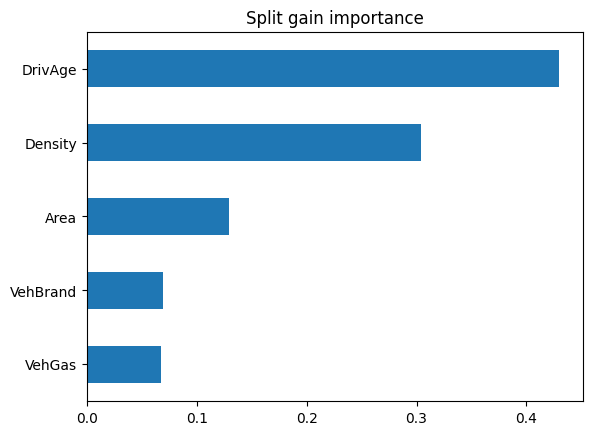

In [12]:
# Variable importance
feature_names = rf[0].get_feature_names_out()
imps = pd.Series(rf[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot(kind="barh", title="Split gain importance")

### Partial dependence plots

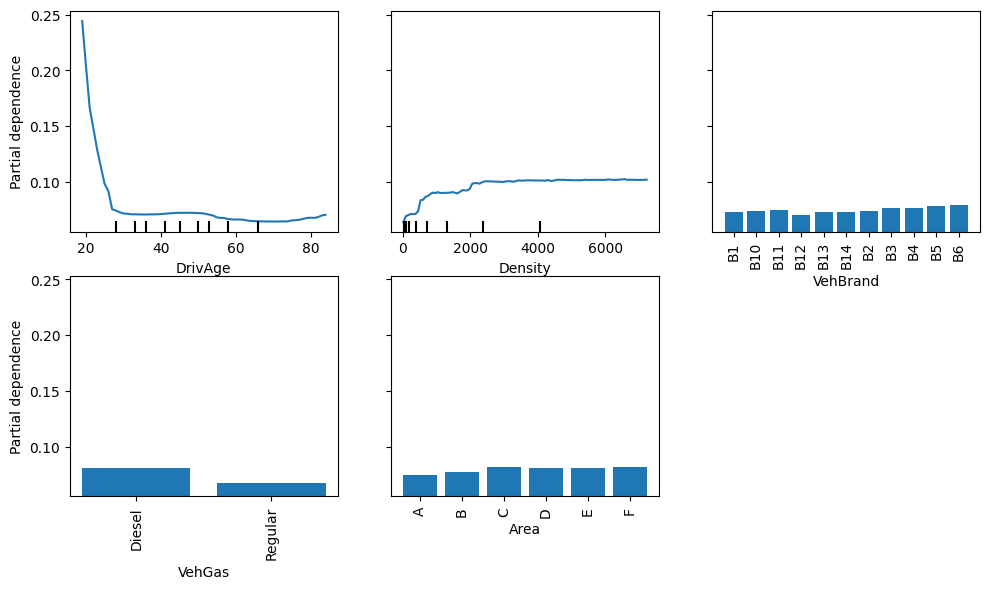

In [13]:
# 1000 rows as background data
df_explain = learn.sample(1000, random_state=1)

fig, axes = plt.subplots(figsize=(10, 6))

PartialDependenceDisplay.from_estimator(
    rf,
    features=feature_names,
    categorical_features=x_cat,
    X=df_explain,
    sample_weight=df_explain["Exposure"],
    n_cols=3,
    ax=axes,
    n_jobs=8,
    random_state=1,
)
fig.tight_layout()

### Surrogate model

As an application of a single decision tree, we approximate the predictions of the black box random forest 
by a short decision tree. This gives a rough explanation of the black box. The R-squared of this surrogate model quantifies how well the approximation works.

R^2 (approximation quality): 0.792


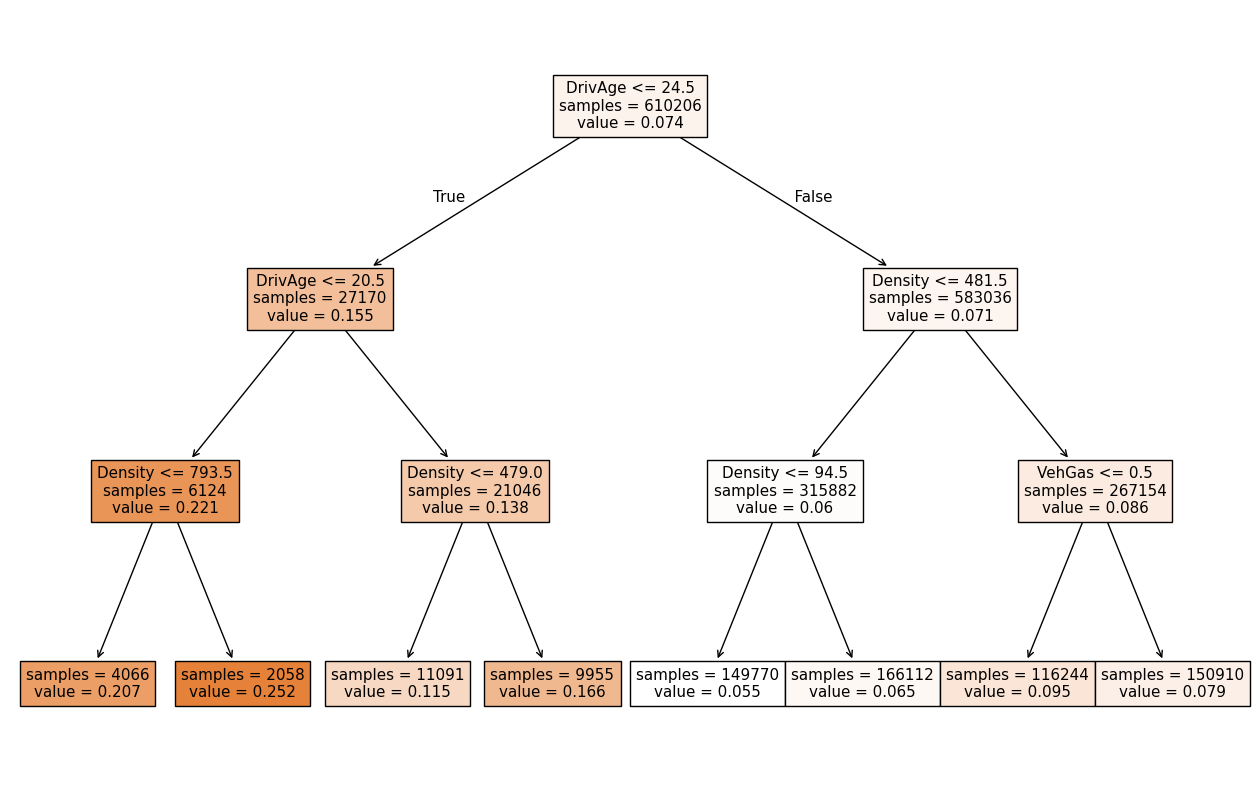

In [14]:
pred_learn = rf.predict(learn)

surrogate_tree = DecisionTreeRegressor(criterion="squared_error", max_depth=3)
surrogate_tree.fit(X_learn, y=pred_learn, sample_weight=v_learn)

plt.figure(figsize=(16, 10))
_ = tree.plot_tree(
    surrogate_tree, feature_names=X_learn.columns, filled=True, impurity=False
)

r_squared = surrogate_tree.score(X_learn, y=pred_learn, sample_weight=v_learn)
print(f"R^2 (approximation quality): {r_squared:.3f}")